## Imports

In [1]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Model selection and evaluation
from sklearn.model_selection import  train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

# Visualization (repeated, you may consider removing one of these)


# Metrics for model evaluation
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score

# Get data

In [2]:
df = pd.read_csv("../data/train.csv")

# Inital data Analysis:

In [18]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
target="Survived"
# Checking that your target variable is binary
# sns.countplot(x=target, data=df, palette='hls')


# inital Preprocessing


## Checking for missing values

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Taking care of missing values


## Dropping missing values


 So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
- Survived - This variable is obviously relevant.
 - Pclass - Does a passenger's class on the boat affect their survivability?
- Sex - Could a passenger's gender impact their survival rate?
- Age - Does a person's age impact their survival rate?
 - SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
 - Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
 - Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
 - Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.
 
 What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. And as you recall, the cabin variable is almost all missing values, so we can just drop all of these.


In [7]:
df_new = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_new.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


# Each feature inspected

## pclass

<Axes: xlabel='Pclass'>

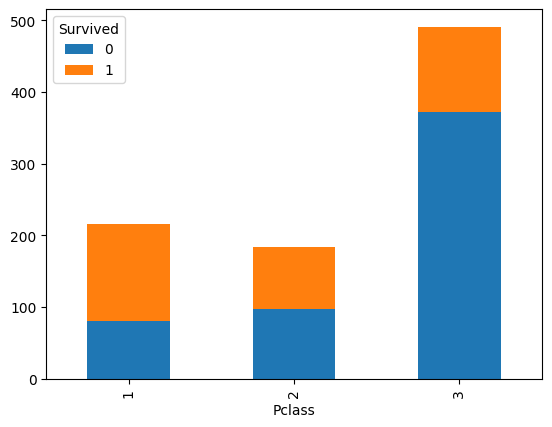

In [8]:
df.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)


Pclass. It seems that Pclass is useful and requires no changes. Passengers with Pclass 3 have less chances for survival. This is reasonable, as passengers with more expensive tickets lived at higher decks and thus could get to lifeboats faster.

## Name

Names by themselves are useful. One way to use them is grouping people by family names - maybe families have better chance for survival? But it is complicated, and there is a better way to create a feature for families. Another way is extracting a title from the name and using it. Let's try.


In [27]:
import re
df['Title'] = df['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [28]:

# %% [markdown]
# There are many titles, in fact it is a bad idea to use them as they are - I tried and the accuracy got worse. A good idea is grouping them by social status or something like that. I have found several ways to group them. Here is the one I chose.

# %%
titles = {'Capt':       'Officer',
          'Col':        'Officer',
          'Major':      'Officer',
          'Jonkheer':   'Royalty',
          'Don':        'Royalty',
          'Sir' :       'Royalty',
          'Dr':         'Officer',
          'Rev':        'Officer',
          'Countess':   'Royalty',
          'Dona':       'Royalty',
          'Mme':        'Mrs',
          'Mlle':       'Miss',
          'Ms':         'Mrs',
          'Mr' :        'Mr',
          'Mrs' :       'Mrs',
          'Miss' :      'Miss',
          'Master' :    'Master',
          'Lady' :      'Royalty'
                    } 

for k,v in titles.items():
    df.loc[df['Title'] == k, 'Title'] = v
    df.loc[df['Title'] == k, 'Title'] = v

#New frequencies.
df['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

## Age


Missing values for Age should be filled. I think that simple mean/median isn't good enough. So I tried several ways to group other columns and chose median by Sex, Pclass and Title.


In [ ]:
# print(df.groupby(['Sex', 'Pclass', 'Title', ])['Age'].median())

# # %%
# df['Age'] = df.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))
# df['Age'] = df.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))

## Sex


At first I wanted to divide passengers into males, females and children, but it increased overfitting. Also I tried to replace values with 1 and 0 (instead of creating dummies), it also worked worse. So doing nothing here.


In [29]:

# %%
# df.groupby(['Pclass', 'Sex'])['Survived'].value_counts(normalize=True)


Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64

## SibSp and Parch



Number of Siblings/Spouses and Parents/Children Aboard. Basically - amount of family members. So if we sum them, we get the size of the family. At first I created a single feature showing whether the person had family. It wasn't good enough. Then I tried several variants and stopped on four groups: 0 relatives, 1-2, 3 and 5 or more. From the table below we can see that such grouping makes sense.


In [31]:
df['Family'] = df['Parch'] + df['SibSp']


In [32]:

# %%
df.groupby(['Family'])['Survived'].value_counts(normalize=True)


Family  Survived
0       0           0.696462
        1           0.303538
1       1           0.552795
        0           0.447205
2       1           0.578431
        0           0.421569
3       1           0.724138
        0           0.275862
4       0           0.800000
        1           0.200000
5       0           0.863636
        1           0.136364
6       0           0.666667
        1           0.333333
7       0           1.000000
10      0           1.000000
Name: Survived, dtype: float64

In [33]:

# %%
def FamilySize(x):
    """
    A function for Family size transformation
    """
    if x == 1 or x == 2:
        return 'little'
    elif x == 3:
        return 'medium'
    elif x >= 5:
        return 'big'
    else:
        return 'single'

df['Family'] = df['Family'].apply(lambda x : FamilySize(x))

In [34]:
df.groupby(['Pclass', 'Family'])['Survived'].mean()


Pclass  Family
1       big       0.500000
        little    0.734043
        medium    0.714286
        single    0.540541
2       big       1.000000
        little    0.600000
        medium    0.769231
        single    0.352381
3       big       0.095238
        little    0.384615
        medium    0.666667
        single    0.205357
Name: Survived, dtype: float64

## Ticket

This value can't be used by itself. Ticket contains prefix and number. Using ticket number doesn't make sense, but prefix could be useful.


In [35]:
def Ticket_Prefix(x):
    """
    Function for extracting prefixes. Tickets have length of 1-3.
    """
    l = x.split()
    if len(x.split()) == 3:
        return x.split()[0] + x.split()[1]
    elif len(x.split()) == 2:
        return x.split()[0]
    else:
        return 'None'

df['TicketPrefix'] = df['Ticket'].apply(lambda x: Ticket_Prefix(x))

# %%
#There are many similar prefixes, but combining them doesn't yield a significantly better result.
df.TicketPrefix.unique()


array(['A/5', 'PC', 'STON/O2.', 'None', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.',
       'SC/PARIS', 'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C',
       'SW/PP', 'SCO/W', 'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle',
       'A/4', 'WE/P', 'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2',
       'S.C./PARIS', 'C.A./SOTON'], dtype=object)

## Fare

There is only one missing value, and in test. Fill it with median for its Pclass.


C:\Users\RhysL\AppData\Local\Temp\ipykernel_20604\1339955443.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(7, 4), ax=ax)


<Axes: xlabel='Pclass', ylabel='Average Fare'>

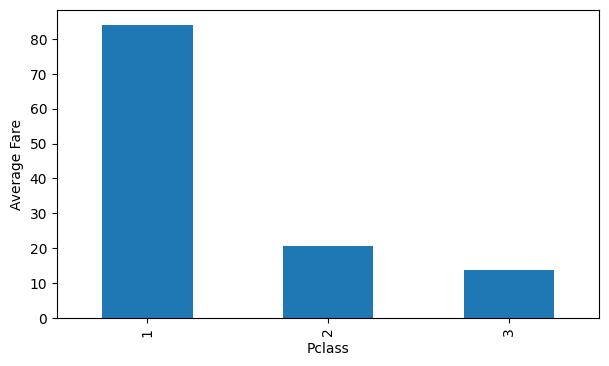

In [39]:
ax = plt.subplot()
ax.set_ylabel('Average Fare')
df.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(7, 4), ax=ax)


In [40]:

df['Fare'] = df.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

C:\Users\RhysL\AppData\Local\Temp\ipykernel_20604\216084659.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Fare'] = df.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))


## Cabin

I thought about ignoring this feature, but it turned out to be quite significant. And the most important for predicting was whether there was information about the Cabin or not.
So I fill NA with 'Unknown" value and use the first letter of the Cabin number as a feature.


In [ ]:

# %%
df.Cabin.fillna('Unknown',inplace=True)

df['Cabin'] = df['Cabin'].map(lambda x: x[0])

# %%
#Now let's see. Most of the cabins aren't filled.
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Cabin', data=df, color='c')

# %%
#Other cabins vary in number.
sns.countplot(y='Cabin', data=df[df.Cabin != 'U'], color='c')

# %%
#Factorplot shows that most people, for whom there is no info on Cabin, didn't survive.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=df[df.Cabin == 'U'], kind='count', size=2.5, aspect=.8)

# %%
#For passengers with known Cabins survival rate varies.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=df[df.Cabin != 'U'], kind='count', size=2.5, aspect=.8)

# %%
df.groupby(['Cabin']).mean()[df.groupby(['Cabin']).mean().columns[1:2]]


## embarked

I simply fill na with most common value.

In [42]:

# %%
MedEmbarked = df.groupby('Embarked').count()['PassengerId']
MedEmbarked

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [ ]:

df.Embarked.fillna(MedEmbarked, inplace=True)


df.head()


# Secondary Preprocessing


## Drop unnecessary columns


In [10]:

to_drop = ['Ticket', 'Name', 'SibSp', 'Parch']
for i in to_drop:
    df.drop([i], axis=1, inplace=True)


## Encoding categoricals

In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Cabin',
       'Embarked'],
      dtype='object')

In [12]:

# %%
#Pclass in fact is a categorical variable, though it's type isn't object.
for col in df.columns:
    if df[col].dtype == 'object':
        dummies = pd.get_dummies(df[col], drop_first=False)
        dummies = dummies.add_prefix('{}_'.format(col))
        df.drop(col, axis=1, inplace=True)
        df = df.join(dummies)


In [13]:
df.head()

,PassengerId,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A10,...,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,7.2500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,38.0,71.2833,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,1,26.0,7.9250,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,35.0,53.1000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,35.0,8.0500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Imputation

In [16]:
df.isnull().sum()

PassengerId      0
Survived         0
Age            177
Fare             0
Pclass_1         0
              ... 
Cabin_G6         0
Cabin_T          0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Length: 159, dtype: int64

In [21]:
df.Age = df.Age.fillna(df.Age.mean())

df.isnull().sum()

PassengerId    0
Survived       0
Age            0
Fare           0
Pclass_1       0
              ..
Cabin_G6       0
Cabin_T        0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Length: 159, dtype: int64

In [ ]:

# %% [markdown]
# ### Imputing missing values

# %%
sns.boxplot(x='Parch', y='Age', data=df, palette='hls')
Parch_groups = df.groupby(df['Parch'])
Parch_groups.mean()


In [ ]:

def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
        
    else:
        return Age
df['Age']= df[['Age', 'Parch']].apply(age_approx, axis=1)
df.isnull().sum()
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.info())


# Relations

## Checking for independence between features

C:\Users\RhysL\AppData\Local\Temp\ipykernel_20604\603683242.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Title,Family,TicketPrefix
0,1,0,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,NaN,S,Mr,little,A/5
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C85,C,Mrs,little,PC
2,3,1,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,NaN,S,Miss,single,STON/O2.
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,C123,S,Mrs,little,None
4,5,0,"Allen, Mr. William Henry",male,35.0,0,0,373450,NaN,S,Mr,single,None


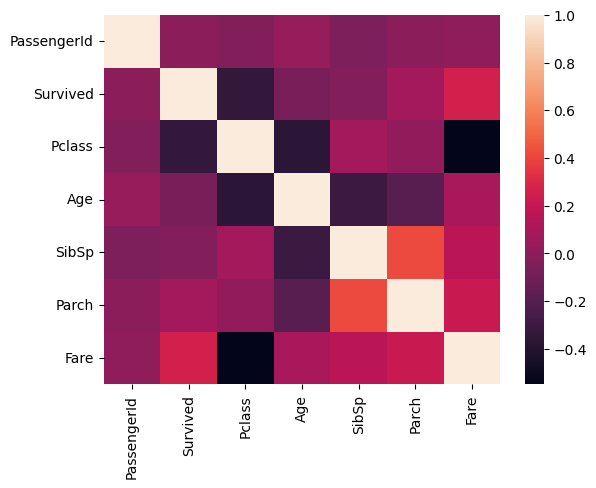

In [43]:

# %%
sns.heatmap(df.corr())
df.drop(['Fare','Pclass'], axis=1, inplace=True)
df.head()

# Modeling

In [23]:
X = df.drop(target,axis='columns')
y = df[target]

In [49]:
X.columns
dropnames=['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'Embarked', 'Title', 'Family', 'TicketPrefix']
X.drop(dropnames)

Index(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'Embarked', 'Title', 'Family', 'TicketPrefix'],
      dtype='object')


## Model prep data


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## Naive bayse


In [25]:
model = GaussianNB()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.6268656716417911

In [29]:
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy}')
cross_val_score(GaussianNB(),X_train, y_train, cv=5)

Model Accuracy: 0.6268656716417911


array([0.648     , 0.672     , 0.664     , 0.64516129, 0.66129032])

## Random Forest


In [30]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)
# Calculate the accuracy using model.score
accuracy = model.score(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.8917910447761194


### Picking parameters for random forest

In [ ]:
# %% [markdown]
# I saw the next part of code there: https://www.kaggle.com/creepykoala/titanic/study-of-tree-and-forest-algorithms
# This is a great way to see how parameters influence the score of Random Forest.

# %%
plt.figure(figsize=(15,10))


In [ ]:

#N Estimators
plt.subplot(3,3,1)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(n_estimators=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('N Estimators')
plt.grid()


In [ ]:

#Criterion
plt.subplot(3,3,2)
feature_param = ['gini','entropy']
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(criterion=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.title('Criterion')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid()


In [ ]:

#Max Features
plt.subplot(3,3,3)
feature_param = ['auto','sqrt','log2',None]
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_features=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(scores, '.-')
plt.axis('tight')
plt.title('Max Features')
plt.xticks(range(len(feature_param)), feature_param)
plt.grid()


In [ ]:

#Max Depth
plt.subplot(3,3,4)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_depth=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Depth')
plt.grid()


In [ ]:

#Min Samples Split
plt.subplot(3,3,5)
feature_param = range(1,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_samples_split =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Samples Split')
plt.grid()


In [ ]:

#Min Weight Fraction Leaf
plt.subplot(3,3,6)
feature_param = np.linspace(0,0.5,10)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(min_weight_fraction_leaf =feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Min Weight Fraction Leaf')
plt.grid()


In [ ]:

#Max Leaf Nodes
plt.subplot(3,3,7)
feature_param = range(2,21)
scores=[]
for feature in feature_param:
    clf = RandomForestClassifier(max_leaf_nodes=feature)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
plt.plot(feature_param, scores, '.-')
plt.axis('tight')
plt.title('Max Leaf Nodes')
plt.grid()


In [ ]:
plt.show()


Now based on these graphs I tune the model. Normally you input all parameters and their potential values and run GridSearchCV.



In [ ]:


# %%
forest = RandomForestClassifier(max_depth = 50,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)

parameter_grid = {'n_estimators' : [15, 100, 200],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2', None]
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


In [ ]:

# %%
forest = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None)
parameter_grid = {
                  'max_depth' : [None, 50],
                  'min_samples_split' : [7, 11],
                  'min_weight_fraction_leaf' : [0.0, 0.2],
                  'max_leaf_nodes' : [18, 20],
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


In [ ]:

# %%
#My optimal parameters
clf = RandomForestClassifier(n_estimators = 200,
                                criterion = 'entropy',
                                max_features = None,
                                max_depth = 50,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)

clf.fit(X, Y_train)
Y_pred_RF = clf.predict(Xt)

clf.score(X_test,y_test)


## logistic regression


In [31]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
y_pred = LogReg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
y_train_pred = cross_val_predict(LogReg, X_train, y_train, cv=5)

In [32]:
confusion_matrix(y_train, y_train_pred)

NameError: name 'y_train_pred' is not defined

In [ ]:
precision_score(y_train, y_train_pred)

# Make a test prediction


In [ ]:

df[863:864]
test_passenger = np.array([866, 40, 0, 0, 0, 0, 0, 1]).reshape(1,-1)
print(model.predict(test_passenger))
print(model.predict_proba(test_passenger))

